In [1]:
# script to fit a curve to the observed mu*-tau by minimizing MSE
# return the modeled curve, the fit statistics, and greens function 
# author: sofia chelpon
# date created: 2-12-2020

In [2]:
import numpy as np 
import xarray as xr
import pandas as pd 
import datetime 
import seaborn as sns
from scipy.signal import find_peaks
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

import datetime as dt 

import matplotlib
from matplotlib import pyplot as plt
import matplotlib.ticker as mticker
from mpl_toolkits import mplot3d

%matplotlib inline
%config inlinebackend.figure_format='retina'

In [3]:
# ---------- read in data 
contrast_ratios = pd.read_pickle("/mnt/home/sofia/TTS/paper_2020/get_ratios/contrast_ratios.pkl")
ratios_sort = contrast_ratios.sort_values(['BL_tau'])

In [31]:
# ---------- prepare some inputs for the function 
# LT in seconds 
tau = ratios_sort['BL_tau'].values
LT = (tau)*86400
# range of times that span all lifetimes, interval of 1/4 of a day 
time1 = LT[0]
time2 = LT[-1]+1
interval = 86400/4 
t = np.arange(time1, time2, interval)

# construct exp(-time/LT) time series
# used to get mu_star_integral
exp_decay_matrix = np.empty((len(LT), len(t)))
for ii, tt in enumerate(LT):
    exp_decay_matrix[ii] = np.exp(-t/tt)

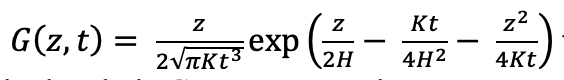

In [5]:
# ------------------------- greens function ----------------------------
# construct the analytical form of the greens function and use gauss newton least squares method
# follow schoeberl et al 2005 (see above MD cell)
def my_greens_func(k_coef, t):
    # z = mid level of sampling, 13 km, H is scale height of atmosphere 
    z = 1.3e4 
    H = 7.64e3 
    # use analytical form to solve for GF 
    a = z/(2*np.sqrt(np.pi*k_coef*(t**3)))
    b = (z/(2*H))-((k_coef*t)/(4*(H**2)))-((z**2)/(4*k_coef*t))
    my_gf = a*np.exp(b)
    # then get mu_star
    mu_star_matrix = np.empty((len(LT), len(t)))
    my_mu_star = np.empty((len(LT), 1))
    for ii, tt in enumerate(LT):
        mu_star_matrix[ii] = exp_decay_matrix[ii]*my_gf    
        my_mu_star[ii] = np.trapz(mu_star_matrix[ii], t)
    # return mu star and greens function 
    return [my_gf, my_mu_star]

In [6]:
##############################################################################################

In [7]:
# ------------------------- iteratively find best k value ----------------------------

0.00626226251831329 0.006262203352079984 141 0.939870430058246


Text(0.5, 1.0, 'demonstrate iteratively finding best k (min MSE method)')

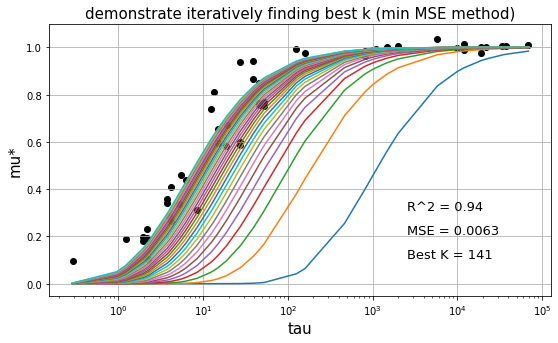

In [23]:
# start with a stupid low k value, define interval to incrase by 
k_coef = 1 
k_plus = 5

# huge MSE to start statement 
MSE_prev = 1000
MSE_now = 999

# state 'true values'
utbl = ratios_sort['All RF']

# iteratively find k 
fig = plt.figure(figsize=(9, 5))
plt.scatter(LT/86400, utbl, color = 'k')
while (MSE_prev > MSE_now):
    # get greens function using k (first pass is dummy k, increases every iteration)
    out = my_greens_func(k_coef, t)
    my_gf = out[0]
    my_mu_star = out[1]
    # add mustar to plot 
    plt.semilogx(LT/86400, my_mu_star)
    # overwrite previous MSE from last lass, calculate new MSE
    MSE_prev = MSE_now
    MSE_now = mean_squared_error(utbl, my_mu_star)
    # increase k coefficient by 10 for next pass
    # will go as long as MSE is still improving
    k_coef = k_coef+k_plus
    my_r2 = r2_score(utbl, my_mu_star)
# rename output best k for use 
best_k = k_coef-(2*k_plus)
mse = MSE_prev
    
print(MSE_now, MSE_prev, best_k, r2)

plt.text(10**3.4, 0.31, 'R^2 = '+ str(round(r2, 2)), size=13)
plt.text(10**3.4, 0.21, 'MSE = '+ str(round(mse, 4)), size=13)
plt.text(10**3.4, 0.11, 'Best K = '+ str(round(best_k, 2)), size=13)

plt.grid(which = 'major')
plt.xlabel('tau', fontsize = 15)
plt.ylabel('mu*', fontsize = 15)
plt.title('demonstrate iteratively finding best k (min MSE method)', fontsize = 15)

# save 
# fig.savefig('fit_k_demo.pdf')  

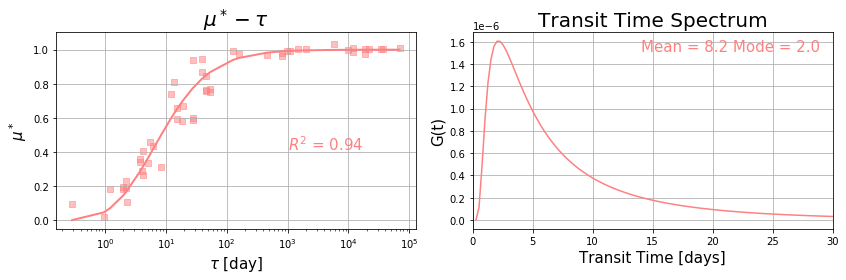

In [49]:
# https://dziganto.github.io/data%20science/linear%20regression/machine%20learning/python/Linear-Regression-101-Metrics/
# use previous to now plot the best fit 
# use best_k to get 
out = my_greens_func(best_k, t)
my_gf = out[0]
my_mustar = out[1]
my_color = [1, 0.5, 0.5]

overplot = 0
scatter = 1
add_r2 = 1 
add_meanmode = 1

# --------------- plot 
# ----- make axes if first plot, overplot = 0 
if (overplot == 0):
    fig, axes = plt.subplots(figsize=(12, 4), ncols=2)
    ax0, ax1 = axes
# ----- my mu star 
ax0.plot(tau, my_mustar, color = my_color, linewidth = 2)
if (scatter == 1):
    ax0.scatter(tau, utbl, color = my_color, marker = 's', alpha = 0.5)
ax0.set_xscale('log')
ax0.grid(which = 'major')
ax0.set_title(r'$\mu^* - \tau$', fontsize = 20)
ax0.set_xlabel(r'$\tau$ [day]', fontsize = 15)
ax0.set_ylabel(r'$\mu^*$', fontsize = 15)
# add r^2 value text, position based on overplot number 
if (overplot == 0):
    yloc = 0.41
else:
    yloc = 0.41 - (overplot*0.1)
if (add_r2 == 1):
    ax0.text(10**3, yloc, r'$R^2$ = '+ str(round(my_r2, 2)), 
         color = my_color, size=15)

#### my gf 
ax1.plot(t/86400, my_gf, color = my_color)

ax1.set_xlim([0, 30])
ax1.set_xticks(np.arange(0, 35, step=5))
ax1.grid(which = 'major')
ax1.set_title('Transit Time Spectrum', fontsize = 20)
ax1.set_ylabel('G(t)', fontsize = 15)
ax1.set_xlabel('Transit Time [days]', fontsize = 15)

# get mean, mode
peaks, _ = find_peaks(my_gf)
mode = t[peaks[0]]/86400
mean = np.trapz(my_gf*t, t)/86400

# add r^2 value text, position based on overplot number 
ymin, ymax = ax1.get_ylim()
if (overplot == 0):
    yloc = ymax*0.9
else:
    yloc = 0.41 - (overplot*0.1)
    
mmstr = 'Mean = '+ str(round(mean, 1)) + ' Mode = ' + str(round(mode, 1))
ax1.text(14, yloc, mmstr, color = my_color, size=15)

plt.ticklabel_format(axis = 'y', style = 'sci', scilimits=(-2,2))
plt.tight_layout()

# fig.savefig('tts_figure.pdf')  